# SST Experimental Prediction with LSTM on Different Time Windows - HCMR/IO 

# 1. Retrieve data file 

In [1]:
# File sharing link from Google Drive: https://drive.google.com/file/d/1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT/view?usp=share_link
!gdown 1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT

Downloading...
From: https://drive.google.com/uc?id=1bzBtzGe80qVpRhUxFiBwKI2ouSu9bmxT
To: /home/posuser/AI/Konstantinos/2) Κώδικας 1D/LSTM-DifferentWindows/cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.nc
100%|██████████████████████████████████████| 95.5k/95.5k [00:00<00:00, 1.26MB/s]


# 2. Read data

In [2]:
# Read NetCDF
import xarray as xr
import pandas as pd

ds = xr.open_dataset('./cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.nc')
df = ds.to_dataframe().reset_index()
df.to_csv('cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.csv', index = False)
df.columns

Index(['time', 'lat', 'lon', 'analysed_sst'], dtype='object')

In [3]:
# Read CSV
df = pd.read_csv('cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021_1668706671579.csv', header=0, parse_dates=['time'], index_col=['time'])

# Convert Kelvin to Celsius
df["celsius"] = df['analysed_sst'] - 273.15

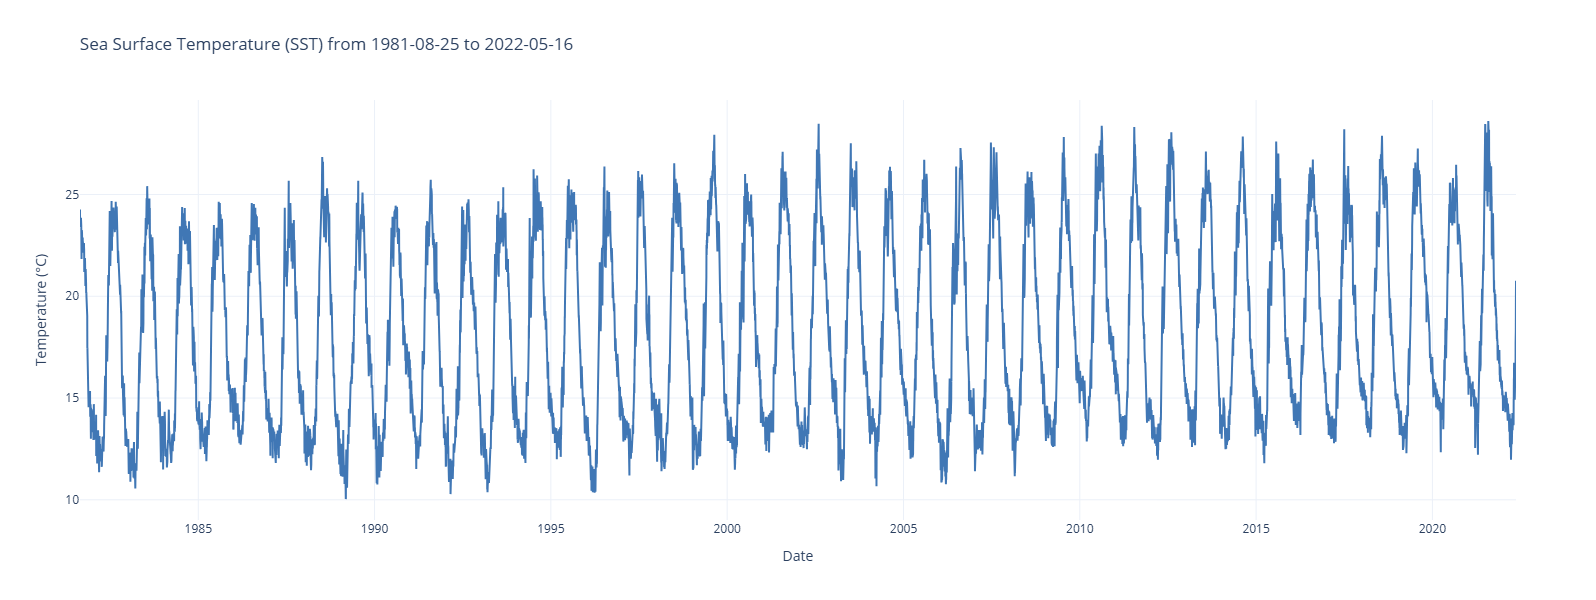

In [4]:
# Print timeseries
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=df.index ,y=df['celsius'], line=dict(color='rgb(64, 119, 181)')))

fig.update_layout(
    autosize=True,
    height=600,
    title="Sea Surface Temperature (SST) from "+str(df.index.date.min())+" to "+str(df.index.date.max())+"",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    template='plotly_white'
)

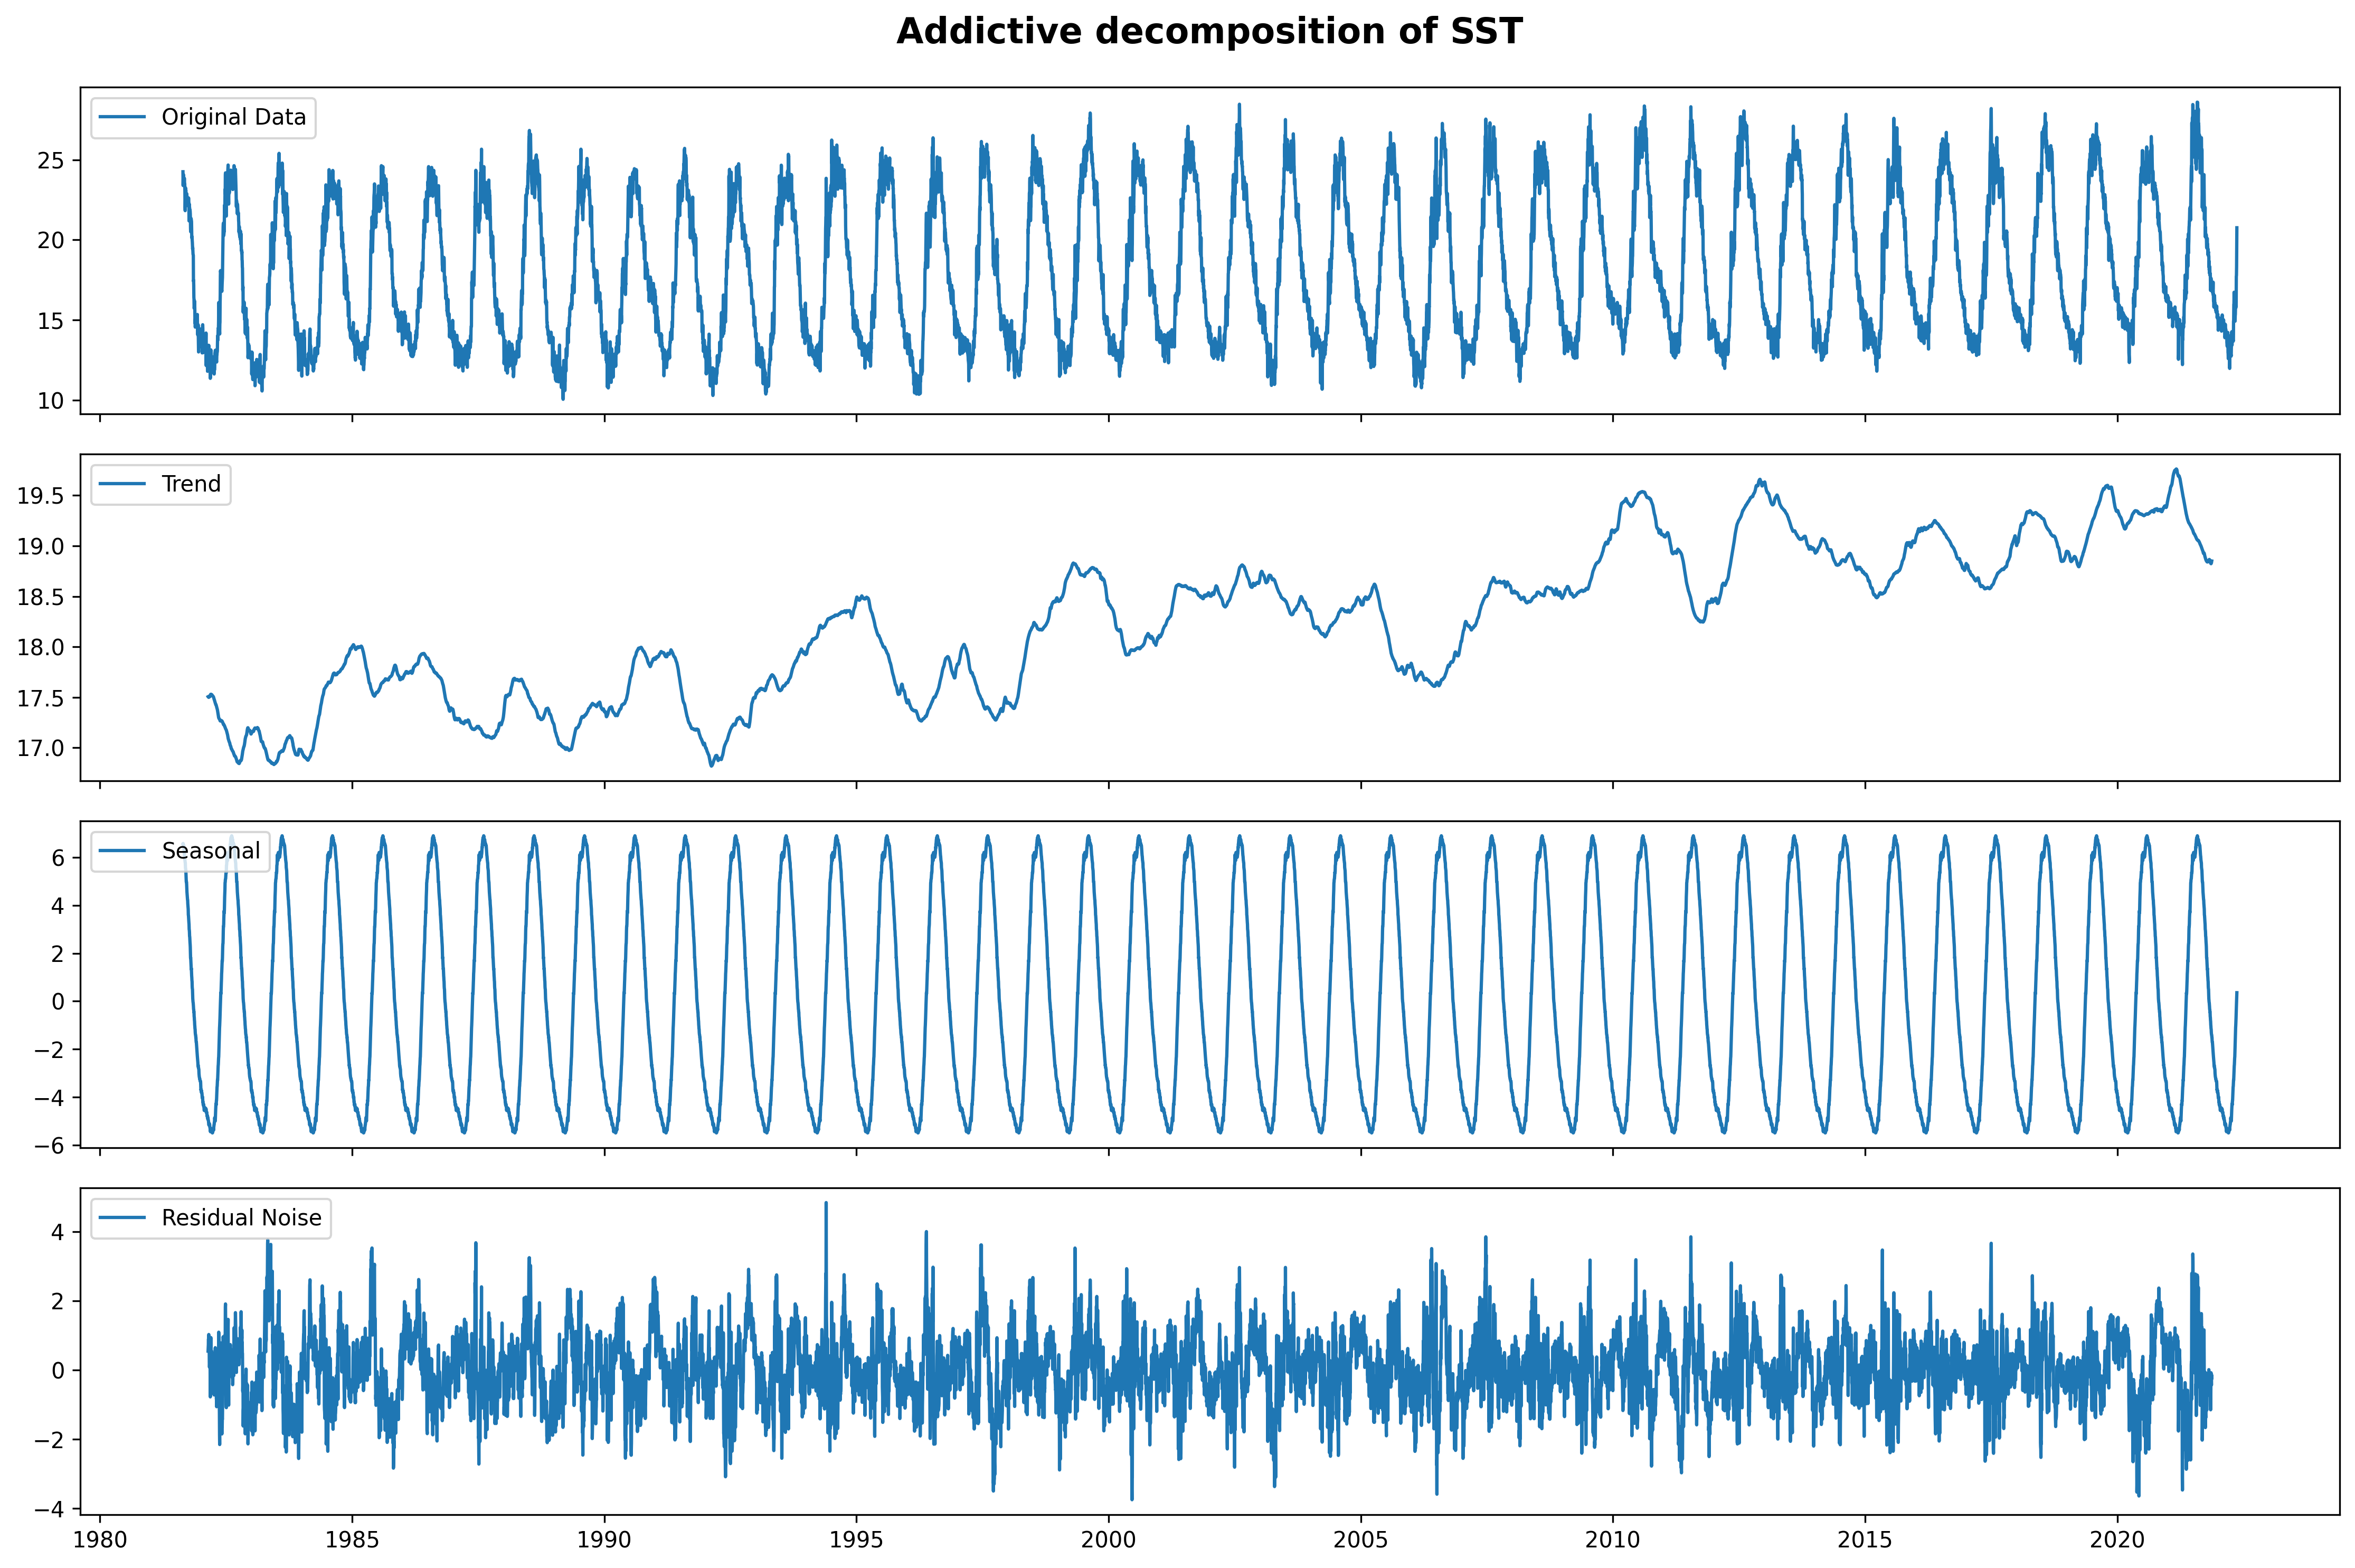

In [5]:
# Print timeseries decomposition, trend, residuals etc.
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = 15, 10
rcParams['figure.dpi'] = 300

decomp = seasonal_decompose(df["celsius"], model='additive', period=365)
printing_results = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
labels = ['Original Data','Trend','Seasonal','Residual Noise']
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=False)
axes[0].set_title("Addictive decomposition of SST", fontweight='bold', fontsize=16, pad=20)
for i, ax in enumerate(axes):
  axes[i].plot(printing_results[i],label=labels[i])
  axes[i].legend(loc="upper left")

plt.tight_layout()
plt.show()

# 3. Data preprocessing

## 3.1 Exploratory analysis of data

In [6]:
# Missing values check
df.isnull().sum()

lat             0
lon             0
analysed_sst    0
celsius         0
dtype: int64

In [7]:
# NAN values check
df.isna().sum()

lat             0
lon             0
analysed_sst    0
celsius         0
dtype: int64

In [8]:
# Print number of dates of our dataset
len(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'))

14875

In [9]:
# Summary statistics of SST
df.celsius.describe()

count    14875.000000
mean        18.204773
std          4.516205
min         10.040000
25%         14.090000
50%         17.269980
75%         22.540000
max         28.609980
Name: celsius, dtype: float64

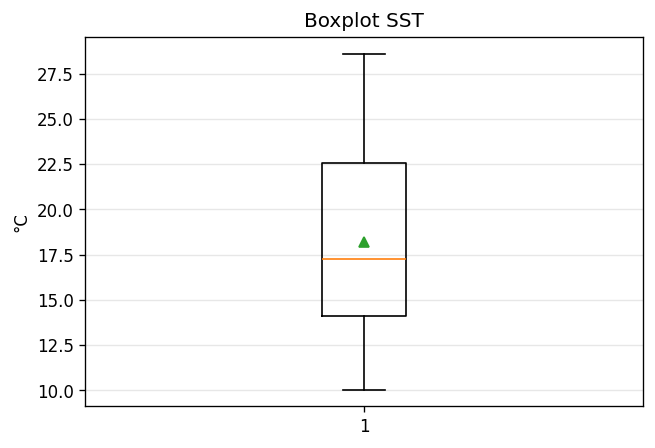

In [10]:
# Boxplot for extreme values check
plt.figure(figsize=(6,4), dpi=120)
plt.boxplot(df["celsius"], vert=True, showmeans=True)
plt.title("Boxplot SST")
plt.ylabel("°C")
plt.grid(axis="y", alpha=0.3)
plt.show()

(array([ 408., 2684., 2799., 1687., 1228., 1331., 1539., 2003., 1006.,
         190.]),
 array([10.04    , 11.896998, 13.753996, 15.610994, 17.467992, 19.32499 ,
        21.181988, 23.038986, 24.895984, 26.752982, 28.60998 ]),
 <BarContainer object of 10 artists>)

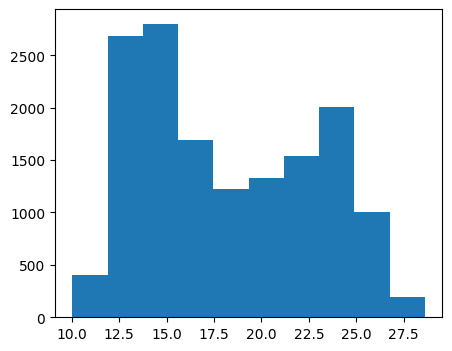

In [11]:
# Histplot for distribution check
plt.figure(figsize=(5,4), dpi=100)
plt.hist(df.celsius)

## 3.2 Split of data in three parts (70% for training, 15% for validation, 15% for testing)

In [12]:
# Print days used per pipeline phase 
df_initial = df.copy()
df = df['celsius'].to_frame()

total = len(df.index) 
calc_15_percent = int(round(total * 0.15)) 
calc_75_percent = int(round(total * 0.75)) 
print (f'Total data = {total} days')
print (f'75% of data = {calc_75_percent} days')
print (f'15% of data= {calc_15_percent} days')

Total data = 14875 days
75% of data = 11156 days
15% of data= 2231 days


In [13]:
# Split train and test data (trainning and testing)
# The test_size parameter is the percentage of the test data, while the shuffle parameter is the random distribution of the data before the splitting
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=calc_15_percent, shuffle=False)
print(f'Trainning data = {len(train_data)} days \nTesting data = {len(test_data)} days')

Trainning data = 12644 days 
Testing data = 2231 days


In [14]:
# Split train and test data (trainning-validation and testing)
train_data, validation_data = train_test_split(train_data, test_size=len(test_data), shuffle=False)
print(f'Trainning data = {len(train_data)} days \nValidation data = {len(validation_data)} days')

Trainning data = 10413 days 
Validation data = 2231 days


### 3.2.1 Visualize the data split

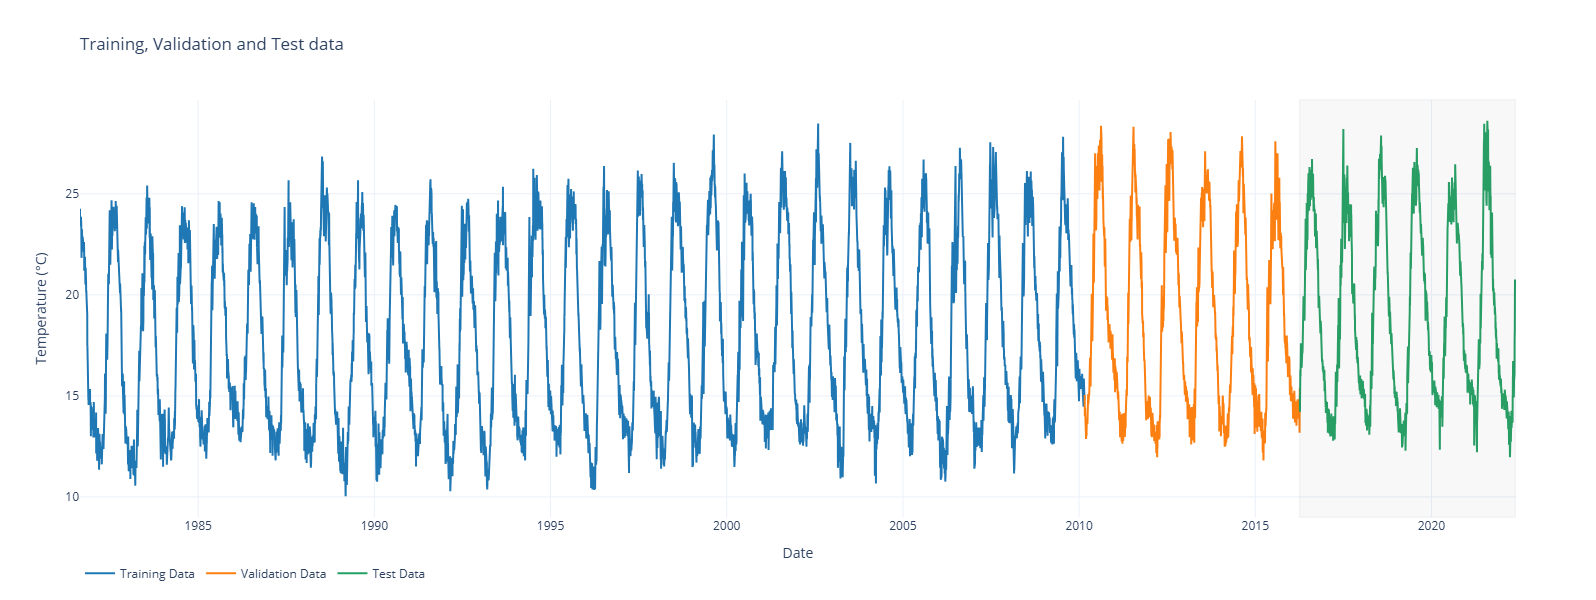

In [15]:
# Visualize the trainning data, validation and testing data in the timeseries
df_splitted_all = pd.DataFrame(columns=['train','validation','test'], index=df.index) 
df_splitted_all['train']= train_data
df_splitted_all['validation']= validation_data
df_splitted_all['test']= test_data

fig = go.Figure()
fig.add_vrect(x0=test_data.index[0], x1=test_data.index[-1], fillcolor="gray", opacity=0.05)
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['train'], line=dict(color="rgb(31,119,180)"), name='Training Data'))
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['validation'], line=dict(color="rgb(251,127,17)"), name='Validation Data'))
fig.add_trace(go.Scatter(mode='lines', x=df_splitted_all.index, y=df_splitted_all['test'], line=dict(color="rgb(35,160,100)"), name='Test Data'))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    # width=800,
    height=600,
    title="Training, Validation and Test data", #for "+str(df.index.year.min())+" - "+str(df.index.year.max()),
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    template='plotly_white'
)

In [16]:
# Print the dates of each sub-dataset
print(f'''Trainning data: {train_data.index.date.min()} to {train_data.index.date.max()}
Validation data: {validation_data.index.date.min()} to {validation_data.index.date.max()}
Testing data: {test_data.index.date.min()} to {test_data.index.date.max()}''')

Trainning data: 1981-08-25 to 2010-02-26
Validation data: 2010-02-27 to 2016-04-06
Testing data: 2016-04-07 to 2022-05-16


## 3.3 Normalization of the Data

In [17]:
# Implement normalization
from sklearn.preprocessing import MinMaxScaler

data_scaler = MinMaxScaler() # default normalization (0,1)
data_scaler.fit_transform((df['celsius'].values).reshape(-1, 1)) # use 2D transformation by reshape(-1, 1) function

train_data_scaled = data_scaler.transform(train_data.values)
validation_data_scaled = data_scaler.transform(validation_data.values)
test_data_scaled = data_scaler.transform(test_data.values)
print("Data shapes:",
      "\nTrain", train_data_scaled.shape,
      "\nValidation", validation_data_scaled.shape,
      "\nTest", test_data_scaled.shape, "\n")
print("Example of normalized data in the validation set:\n", test_data_scaled)

Data shapes: 
Train (10413, 1) 
Validation (2231, 1) 
Test (2231, 1) 

Example of normalized data in the validation set:
 [[0.26655818]
 [0.22509448]
 [0.31664008]
 ...
 [0.44588093]
 [0.52504095]
 [0.5772758 ]]


### 3.3.1 Make batches

In [18]:
window_lag_days = int(input("How many lag days? "))

How many lag days?  12


In [19]:
# Import libraries and define window time and batches in each set
import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batches_for_Train_Data = TimeseriesGenerator(train_data_scaled, # normalized timeseries values
                                             train_data_scaled, # goal (same length with the timeseries)
                                             stride=1, # time step between instances
                                             length=window_lag_days, # window frame time (for prediction)
                                             batch_size=1 # number of tranning data per batch
                                             )

batches_for_Validation_Data = TimeseriesGenerator(validation_data_scaled,
                                                 validation_data_scaled,
                                                 stride=1,
                                                 length=window_lag_days,
                                                 batch_size=1
                                                 )

batches_for_Test_Data = TimeseriesGenerator(test_data_scaled,
                                           test_data_scaled,
                                           stride=1,
                                           length=window_lag_days,
                                           batch_size=1
                                           )

# Example of one batch of tranning data
X,y = batches_for_Train_Data[0]
print(f'Sequence of {window_lag_days} values (Χ): \n{X.flatten()}')
print(f'Goal to predict (y): \n {y.flatten()}')

2026-01-05 11:23:55.330335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 11:23:55.355559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sequence of 12 values (Χ): 
[0.76575204 0.71944073 0.74205788 0.74421082 0.7560579  0.7452889
 0.73290332 0.73774878 0.73398033 0.73398033 0.74421082 0.73505733]
Goal to predict (y): 
 [0.72482577]


2026-01-05 11:23:55.918625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 3.3.2 Define normalized batch results

In [20]:
# Function to create all inputs and it's relevant outputs in different tables
import numpy as np

def get_all_scaled_data(generated_batches):
  data_X_scaled = []
  data_y_scaled = []
  for i in range(len(generated_batches)):
    x, y = generated_batches[i]
    data_X_scaled.append(x.flatten())
    data_y_scaled.append(y.flatten())

  return np.array(data_X_scaled), np.array(data_y_scaled)

# Implement the above to get the array of X and it's corresponding y in the trainning data
train_X_scaled, train_y_scaled = get_all_scaled_data(batches_for_Train_Data)

# Implement the above to get the array of X and it's corresponding y in the validation data
validation_X_scaled, validation_y_scaled = get_all_scaled_data(batches_for_Validation_Data)

# Implement the above to get the array of X and it's corresponding y in the testing data
test_X_scaled, test_y_scaled = get_all_scaled_data(batches_for_Test_Data)

### 3.3.3 Save normalized batch results

In [21]:
# Function to save the previous tables in a CSV file
def save_to_csv(data, X, y, scaled_or_normal='scaled_train_data', print='no', real=''):
  df_csv = pd.DataFrame()
  df_csv = pd.DataFrame(X, columns=['X'+str(i) for i in range(1, window_lag_days+1)], index=data.index[window_lag_days:]) 
  df_csv["TARGET"] = y
  if real == 'real':
    for i in range(horizon):
      df_csv["REAL"+str(i+1)] = data[window_lag_days:].shift(-i)

  df_csv.to_csv(scaled_or_normal+'.csv')
  if print == 'yes':
    return df_csv

# CSV export of tranning data with normalized values
#save_to_csv(train_data, train_X_scaled, train_y_scaled, 'scaled_train_data')

# CSV export of tranning data with Celcius values
normal_X_train = data_scaler.inverse_transform(train_X_scaled)
normal_y_train = data_scaler.inverse_transform(train_y_scaled)
#save_to_csv(train_data, normal_X_train, normal_y_train, f'normal_train_data_{window_lag_days}')


# CSV export of validation data with normalized values
#save_to_csv(validation_data, validation_X_scaled, validation_y_scaled, f'scaled_validation_data_{window_lag_days}')

#CSV export of validation data with Celcius values
normal_X_validation = data_scaler.inverse_transform(validation_X_scaled)
normal_y_validation = data_scaler.inverse_transform(validation_y_scaled)
#save_to_csv(validation_data, normal_X_validation, normal_y_validation, f'normal_validation_data_{window_lag_days}')


# CSV export of testing data with normalized values
save_to_csv(test_data, test_X_scaled, test_y_scaled, f'scaled_test_data_{window_lag_days}')

# CSV export of testing data with Celcius values
normal_X_test = data_scaler.inverse_transform(test_X_scaled)
normal_y_test = data_scaler.inverse_transform(test_y_scaled)
#save_to_csv(test_data, normal_X_test, normal_y_test, f'normal_test_data_{window_lag_days}')

 #### 3.3.3.1 Save batches with targets

In [22]:
# CSV export of batches (each batch contains 12 days and it's predictor outcome) with Celcius values
all_train = pd.concat([train_data,validation_data[:-12]]) 
all_train_X = np.concatenate((train_X_scaled,validation_X_scaled)) 
all_train_y = np.concatenate((train_y_scaled,validation_y_scaled)) 
normal_all_train_X = data_scaler.inverse_transform(all_train_X)
normal_all_train_y = data_scaler.inverse_transform(all_train_y)
#save_to_csv(all_train, normal_all_train_X, normal_all_train_y, f'normal_all_train_{window_lag_days}')

# 4. LSTM implementation for SST prediction

## 4.1 Definition of hyperparameters 

In [23]:
import time 
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras import metrics
!pip install -q -U keras-tuner

horizon=1 # Number of days for output
n_features=1 # Number of variables used for prediction

In [24]:
# LSTM model creation 
# This, as well as CNN3 and CNN12 trainnings and model definitions can be skipped to the load of the models eg 4.2.4 for LSTM
def model_builder(hp):
  model = keras.Sequential()
  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=200, step=2), 
                 activation='relu',
                 #input_shape (batch_size, time_steps, input_dimension/num_features)
                 #batch_size = None(any size), in TimeseriesGenerator was defined as 1
                 input_shape=(window_lag_days, n_features)
                ))
  model.add(Dense(horizon))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',values=[1e-4, 1e-3])),
                loss= 'mean_squared_error',
                metrics=[metrics.RootMeanSquaredError(name="rmse")]
                )
  return model

# Before running the search kill previous processes to free up space in the GPU (if available the search is been run automatically in this)
!nvidia-smi
#!kill -9 PID #(replace PID with your process identified in the previous command)

Mon Jan  5 11:23:59 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   28C    P8             11W /  130W |     103MiB /  20475MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
# Define Hyperband as the search algorithm
tuner = kt.Hyperband(model_builder,
                     objective= kt.Objective("val_rmse", direction="min"),
                     max_epochs=200,
                     factor=3,
                     directory=f'Hyperband-searches-{window_lag_days}',
                     project_name='Hyperband_units-rate'
                     )

tuner.search_space_summary(extended=True)
stop_early = EarlyStopping(monitor='val_rmse', patience=20, verbose=1) # Early stop of search if the 20 upcoming seasons do not show a better result in RMSE in the validation data

# LSTM hyperparameter search implementation
start_time = time.time()
tuner.search(batches_for_Train_Data,
             epochs=200,
             shuffle=True,
             validation_data=batches_for_Validation_Data,
             callbacks=[stop_early])
end_time = time.time()
search_time = (end_time - start_time)/60

# Retrieve best hyperparameters for LSTM
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
lr_hb = best_hps.get('learning_rate')
units_hb = best_hps.get('units')
print(f"""
The search is complete, the optimized number of nodes to the LSTM is {units_hb}
and the optimized learning rate for the optimizer is {lr_hb}
""")
print(f"LSTM hyperparameter search for {window_lag_days} time window ran in {search_time:.3f} minutes")

Trial 248 Complete [00h 08m 00s]
val_rmse: 0.023653412237763405

Best val_rmse So Far: 0.023332878947257996
Total elapsed time: 12h 30m 05s

Search: Running Trial #249

Value             |Best Value So Far |Hyperparameter
82                |158               |units
0.0001            |0.0001            |learning_rate
200               |200               |tuner/epochs
0                 |67                |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/200
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0048 - rmse: 0.0692 - val_loss: 0.0016 - val_rmse: 0.0404
Epoch 2/200
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0013 - val_rmse: 0.0365
Epoch 3/200
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0011 - rmse: 0.0334 - val_loss: 0.0010 - val_rmse: 0.0319
Epoch 4/200
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 9.8107e-04 - rmse: 0.0313 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## 4.2 Definition of LSTM

In [26]:
# Creation of the LSTM
from keras.models import Sequential

hypermodel_LSTM = Sequential() 
hypermodel_LSTM.add(LSTM(units_hb, activation='relu', input_shape=(window_lag_days, n_features))) 
hypermodel_LSTM.add(Dense(horizon))
hypermodel_LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_hb),
                        loss= 'mean_squared_error',
                        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

# Save of the architecture of the model in JSON file
with open(f"hypermodel_LSTM_fit_{window_lag_days}.json", "w") as m:
    m.write(hypermodel_LSTM.to_json())

In [27]:
# Plot of the LSTM
from keras.utils import plot_model

plot_model(hypermodel_LSTM,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=True,
           dpi=150,
           layer_range=None,
           show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### 4.2.1 Trainning of LSTM

In [28]:
# ModelCheckpoint saves the best weights of the model
from keras.callbacks import ModelCheckpoint 

Model_Checkpoint = ModelCheckpoint(filepath=f'LSTM_window_{window_lag_days}/hypermodel_LSTM.weights.h5', 
                                   monitor= 'val_rmse',
                                   save_weights_only=True,
                                   verbose=1, save_best_only=True)

stop_early = EarlyStopping(monitor='val_rmse', patience=50, verbose=1) # Early stop of search if the 50 upcoming seasons do not show a better result in RMSE in the validation data

# Trainning and save of the history 
start_time = time.time()
history_hypermodel_Trainning = hypermodel_LSTM.fit(batches_for_Train_Data,
                                                   epochs=300,
                                                   verbose=1,
                                                   callbacks=[Model_Checkpoint, stop_early],
                                                   shuffle=True, 
                                                   validation_data=(batches_for_Validation_Data))
end_time = time.time()
train_time = (end_time-start_time)/60
print(f"LSTM trainning for {window_lag_days} time window ran in {train_time:.3f} minutes")

Epoch 1/300
10392/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 - rmse: 0.0828
Epoch 1: val_rmse improved from None to 0.03656, saving model to LSTM_window_12/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0013 - val_rmse: 0.0366
Epoch 2/300
10374/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - rmse: 0.0344
Epoch 2: val_rmse improved from 0.03656 to 0.03477, saving model to LSTM_window_12/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0011 - rmse: 0.0335 - val_loss: 0.0012 - val_rmse: 0.0348
Epoch 3/300
10364/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 3: val_rmse improved from 0.03477 to 0.02711, saving model to LSTM_window_12/hypermodel_LSTM.weights.h5
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 9.3030e-04 - rmse: 0.0305 - val_loss: 7.3518e-04 - val_rmse: 0.0271
Epoch 4/300
10401/10401 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

### 4.2.2 Save of LSTM

In [30]:
# Local save of entire model (all seasons)
hypermodel_LSTM.export(f'LSTM_window_{window_lag_days}/Model')
hypermodel_LSTM.save(f'LSTM_window_{window_lag_days}/Model.keras')
#hypermodel_LSTM.save(f'LSTM_window_{window_lag_days}/Model.h5')

INFO:tensorflow:Assets written to: LSTM_window_12/Model/assets


INFO:tensorflow:Assets written to: LSTM_window_12/Model/assets


Saved artifact at 'LSTM_window_12/Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135248073356112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248073358416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135281557270800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248073357648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248073357840: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
# Save of trainning history
import json
history_dict = history_hypermodel_Trainning.history
json.dump(history_dict, open(f'LSTM_window_{window_lag_days}/hypermodel_LSTM_History.json', 'w'))

history_dict = json.load(open(f'LSTM_window_{window_lag_days}/hypermodel_LSTM_History.json', 'r'))
history_pd = pd.DataFrame(history_dict)

### 4.2.3 Visualization of trainning losses

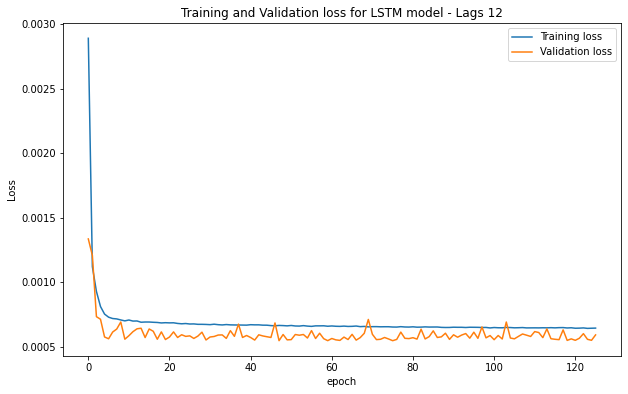

In [32]:
# Visualization per season for trainning and validation data
import matplotlib.pyplot as plt

loss_by_epoch= history_pd['loss']
#val_loss_by_epoch= history_hypermodel_Trainning.history['val_loss']
val_loss_by_epoch= history_pd['val_loss']
plt.figure(figsize = (10, 6), dpi=72)
plt.title(f'Training and Validation loss for LSTM model - Lags {window_lag_days}')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(loss_by_epoch)
plt.plot(val_loss_by_epoch)
plt.legend(['Training loss', 'Validation loss'], loc='best')

### 4.2.4 Load LSTM

In [33]:
# Load LSTM if the files of weights (.h5) and architecture .json exist
import json
from tensorflow.keras.models import model_from_json

with open(f"hypermodel_LSTM_fit_{window_lag_days}.json", "r") as m:
    model_json = m.read()

loaded_model_LSTM = model_from_json(model_json)
loaded_model_LSTM.summary()
loaded_model_LSTM.load_weights(f'LSTM_window_{window_lag_days}/hypermodel_LSTM.weights.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 190)            │       145,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           191 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,335 (1.67 MB)

 Trainable params: 146,111 (570.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 292,224 (1.11 MB)

## 4.3 Prediction of SST

In [34]:
# Load testing data
import pandas as pd

scaled_test_data = pd.read_csv(f"scaled_test_data_{window_lag_days}.csv", index_col=0)  

# Extract input features (exclude last column)
test_X_scaled = scaled_test_data.iloc[:, :-1].values  
print("Shape of test_X_scaled before reshaping:", test_X_scaled.shape)
test_X_scaled = test_X_scaled.reshape(-1, window_lag_days, n_features)
print("Reshaped test_X_scaled:", test_X_scaled.shape)


# Extract target values if needed (last column)
test_y_scaled = scaled_test_data.iloc[:, -1].values  
print("Shape of test_y_scaled before reshaping:", test_y_scaled.shape)
test_y_scaled = test_y_scaled.reshape(-1, 1)  
print("Reshaped test_y_scaled:", test_y_scaled.shape)

# Predictions in testing data
scaled_predictions_y_Test_Data = loaded_model_LSTM.predict(test_X_scaled, batch_size=1)
print("Predictions completed!")

# Load predictions of the model
Real_y_prediction_on_Test= data_scaler.inverse_transform(scaled_predictions_y_Test_Data)

# Load real values of the data 
Inverted_y_from_Test = data_scaler.inverse_transform(test_y_scaled)

Shape of test_X_scaled before reshaping: (2219, 12)
Reshaped test_X_scaled: (2219, 12, 1)
Shape of test_y_scaled before reshaping: (2219,)
Reshaped test_y_scaled: (2219, 1)
2219/2219 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step
Predictions completed!


### 4.3.1 Results

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mae= mean_absolute_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
acc = ((1-(mae/Inverted_y_from_Test.mean()))*100)
mse = mean_squared_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
rmse=sqrt(mse)
mape = mean_absolute_percentage_error(Inverted_y_from_Test,Real_y_prediction_on_Test)
r2 = r2_score(Inverted_y_from_Test,Real_y_prediction_on_Test)

print('Results in testing data:')
print('--------------------------')
print(f'RMSE: {round(rmse,3)} ')
print(f'ACC: {round(acc,3)} ')
print(f'MSE: {round(mse,3)} ')
print(f'MAE: {round(mae,3)} ')
print(f'MAPE: {round(mape,3)} ')
print(f'R^2: {round(r2,3)} ')

Results in testing data:
--------------------------
RMSE: 0.453 
ACC: 98.345 
MSE: 0.205 
MAE: 0.315 
MAPE: 0.017 
R^2: 0.989 


### 4.3.2 Actual and predicted comparisson

In [36]:
plot_df = pd.DataFrame(index=test_data.index[window_lag_days:])
plot_df[["Actual"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Inverted_y_from_Test, columns=['TARGET'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])
plot_df[["Pred"+str(i) for i in range(1, horizon+1)]] = pd.DataFrame(Real_y_prediction_on_Test, columns=['Pred'+str(i) for i in range(1, horizon+1)], index=test_data.index[window_lag_days:])

for i in range(horizon):
      plot_df["Pred"+str(i+1)] = plot_df["Pred"+str(i+1)][:].shift(i)
      plot_df["Diff"+str(i+1)] = plot_df["Pred"+str(i+1)]-plot_df["Actual"+str(i+1)][:]
plot_df.to_csv(f'LSTM_window_{window_lag_days}/test-data-prediction-results-LSTM.csv')

### 4.3.3 Visualization of predictions

In [37]:
# Print correlation 
import scipy
corcoef, pval = scipy.stats.pearsonr(plot_df['Actual1'],plot_df['Pred1'])
print('Corcoef Value: ', corcoef)
print('Corcoef p-value:', pval)

# Save some metrics
results = {
    "RMSE": [rmse],
    "ACC":  [acc],
    "MSE":  [mse],
    "MAE":  [mae],
    "MAPE": [mape],
    "R2":   [r2],
    "Search": [search_time],
    "Training": [train_time],
    "Correlation": [corcoef]
}

df_metrics = pd.DataFrame(results)
df_metrics.to_csv(f"test_metrics_{window_lag_days}.csv", index=False)

Corcoef Value:  0.9945951061902378
Corcoef p-value: 0.0


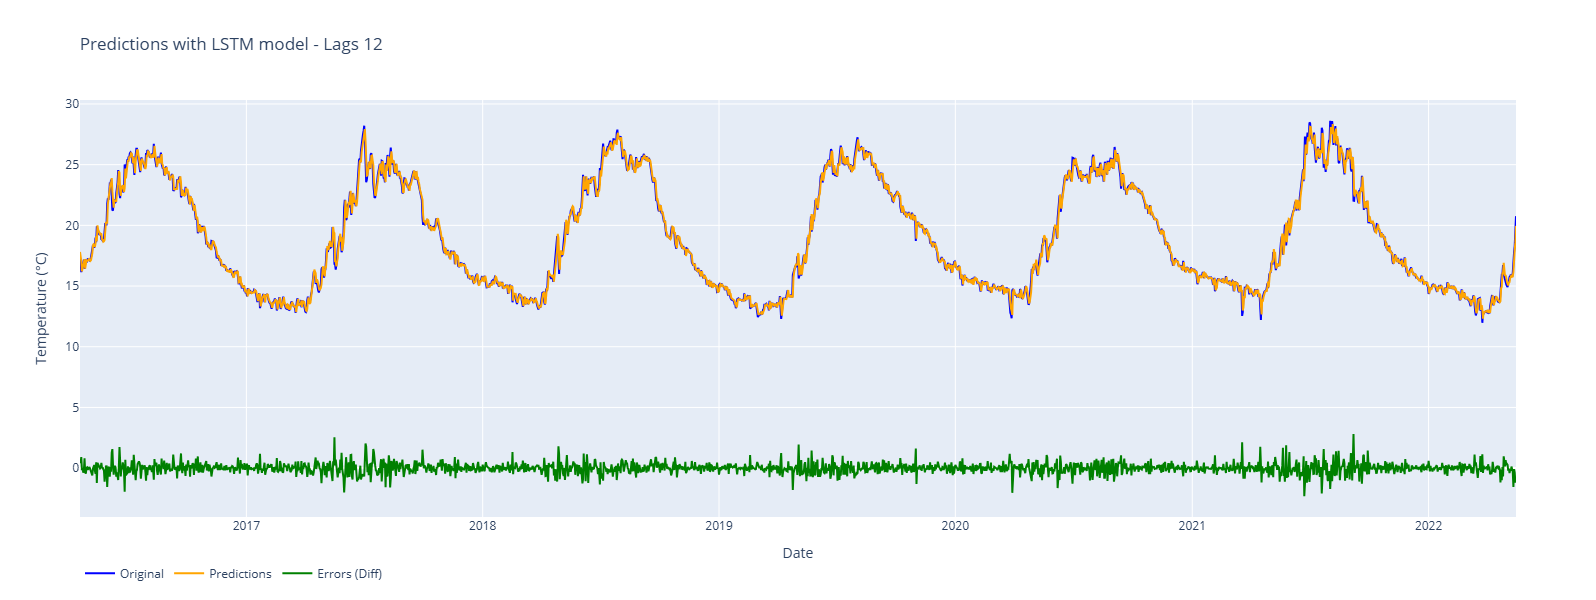

In [38]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Actual1'], line_color='blue', name='Original',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Pred1'], line_color='orange',name='Predictions',xhoverformat="%B %d, %Y"))
fig.add_trace(go.Scatter(mode='lines', x=plot_df.index, y=plot_df['Diff1'], line_color='green',name='Errors (Diff)',xhoverformat="%B %d, %Y"))

fig.update_layout(
    legend=dict(
    orientation="h"),
    autosize=True,
    height=600,
    title=f"Predictions with LSTM model - Lags {window_lag_days}",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)"
)

fig.show()

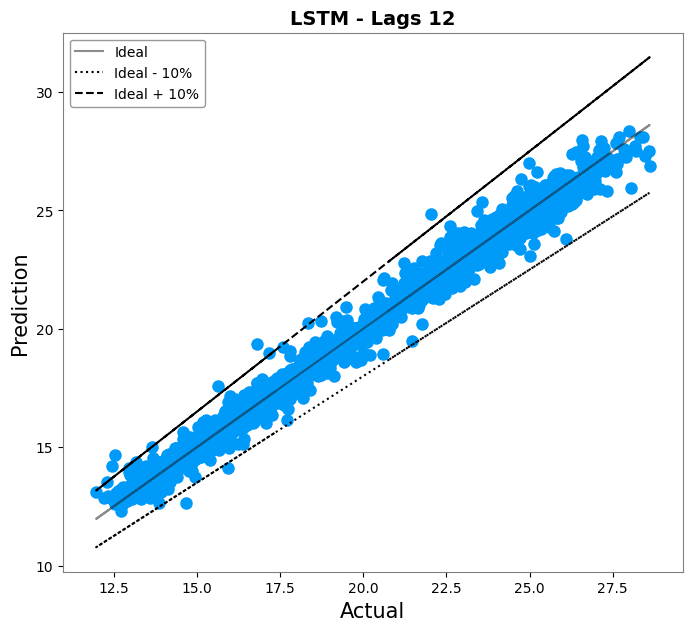

In [39]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

commutes = plot_df
#commutes = pd.read_csv(f'LSTM_window_{window_lag_days}/test-data-prediction-results-LSTM.csv')

# Raw Data
target = np.array(commutes['Actual1']) #[-60:]
prediction = np.array(commutes['Pred1']) #[-60:]

fig, ax = plt.subplots(figsize=(8, 7), dpi=100)
x = target
y = prediction

ax.plot(x, y, "o", fillstyle='full', color="#009af9", markersize=8,
    markeredgewidth=1, #markeredgecolor="b", markerfacecolor="#4077b5"
)

x2 = x
y2 = x2
ax.plot(x2, y2, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Ideal")

ax.plot(x2, y2 - 0.1*y2, ":", color="black", label="Ideal - 10%")
ax.plot(x2, y2 + 0.1*y2, "--", color="black", label="Ideal + 10%")

# Figure Modifications
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Labels
plt.title(f"LSTM - Lags {window_lag_days}", fontsize="14", fontweight="bold")
plt.xlabel("Actual", fontsize=15)
plt.ylabel("Prediction", fontsize=15)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    
legend = plt.legend(
    [handle for i, handle in enumerate(handles)] + [anyArtist],
    [label for i, label in enumerate(labels)],
    #loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)
frame = legend.get_frame().set_edgecolor("0.5")